In [1]:
import os
import numpy as np

from skimage.io import imread, imsave
from skimage.transform import resize

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH = '../data/stage1_train/'
TEST_PATH = '../data/stage1_test/'
PIXELS = 448

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
def normalize_img(img_arr):
    img_min = np.min(img_arr)
    img_max = np.max(img_arr)
    img_mean = np.mean(img_arr)
    img_out = (img_arr - img_mean) / (img_max - img_min)
    return img_out

In [5]:
'''
def load_train_data(tr_path, imsize):
    # get all of the image ids
    train_ids = next(os.walk(tr_path))[1]

    # set up matrices to hold values
    X_imgs = np.zeros((len(train_ids), imsize, imsize, 3), dtype=np.float32)
    Y_msks = np.zeros((len(train_ids), imsize, imsize, 1), dtype=np.bool)

    for n, im_id in enumerate(train_ids[:2]):
        im_path = tr_path + im_id
        img = imread(im_path + '/images/' + im_id + '.png')[:, :, :3] # some images have 4 channels
        img = resize(img, (imsize, imsize), mode='constant', preserve_range=True)
        img = normalize_img(img)
        X_imgs[n] = img
        # concatenate the masks
        mask = np.zeros((imsize, imsize, 1), dtype=np.bool)
        mask_files = next(os.walk(im_path + '/masks/'))[2]
        for i, mask_file in enumerate(mask_files):
            mask_ = imread(im_path + '/masks/' + mask_file)
            mask_ = resize(mask_, (imsize, imsize), 
                           mode='constant', preserve_range=True)
            # combine masks for each nuclei
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_.astype(np.bool))

        plt.figure(1)
        plt.subplot(1,2,1)
        plt.imshow(mask.squeeze())
        plt.title('Mask')
        plt.show()

        # add mask to Y values
        Y_msks[n] = mask

    return X_imgs, Y_msks

def random_cropper(img_path):
    train_ids = next(os.walk(img_path))[1]
    
    n = 0
    for img_id in train_ids:
        img = imread(img_path + img_id + '/images/' + img_id + '.png')[:,:,:3]
        img_h = img.shape[0]
        img_w = img.shape[1]

        mask = np.zeros((img_h, img_w, 1), dtype=np.bool)
        mask_files = next(os.walk(img_path + img_id + '/masks/'))[2]
        for mask_file in mask_files:
            mask_ = imread(img_path + img_id  + '/masks/' + mask_file)
            mask_ = resize(mask_, (img_h, img_w), 
                           mode='constant', preserve_range=True)
            # combine masks for each nuclei
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_.astype(np.bool))

        num_crops = 50
        for _ in range(num_crops):
            xmin = np.random.randint(0, int(img_w * 0.5))
            ymin = np.random.randint(0, int(img_h * 0.5))

            nmax = np.random.randint(0, min(img_w, img_h) - max(xmin, ymin))

            img_cropped = img[ymin:ymin+nmax, xmin:xmin+nmax, :]
            msk_cropped = mask[ymin:ymin+nmax, xmin:xmin+nmax, :]
            
            #if (img_cropped.shape[1] > 10) and (img_cropped.shape[1] > 10) and (img_cropped.shape[2] == 3): 
            #    imsave('../data/random_crops_mask/{}_rnd_img_{}.png'.format(img_id, n), img_cropped)
            #    imsave('../data/random_crops_mask/{}_rnd_msk_{}.png'.format(img_id, n), msk_cropped.squeeze())
            #    n += 1
        
        #plt.figure(1)
        #plt.subplot(1,2,1)
        #plt.imshow(img_cropped)
        #plt.title('Image')
        
        #plt.subplot(1,2,2)
        #plt.imshow(msk_cropped.squeeze())
        #plt.title('Mask')
        #plt.show()
        
        

#X_img, Y_msks = load_train_data(TRAIN_PATH, 448)
random_cropper(TRAIN_PATH)
'''

"\ndef load_train_data(tr_path, imsize):\n    # get all of the image ids\n    train_ids = next(os.walk(tr_path))[1]\n\n    # set up matrices to hold values\n    X_imgs = np.zeros((len(train_ids), imsize, imsize, 3), dtype=np.float32)\n    Y_msks = np.zeros((len(train_ids), imsize, imsize, 1), dtype=np.bool)\n\n    for n, im_id in enumerate(train_ids[:2]):\n        im_path = tr_path + im_id\n        img = imread(im_path + '/images/' + im_id + '.png')[:, :, :3] # some images have 4 channels\n        img = resize(img, (imsize, imsize), mode='constant', preserve_range=True)\n        img = normalize_img(img)\n        X_imgs[n] = img\n        # concatenate the masks\n        mask = np.zeros((imsize, imsize, 1), dtype=np.bool)\n        mask_files = next(os.walk(im_path + '/masks/'))[2]\n        for i, mask_file in enumerate(mask_files):\n            mask_ = imread(im_path + '/masks/' + mask_file)\n            mask_ = resize(mask_, (imsize, imsize), \n                           mode='constant'

In [41]:
import cv2
from scipy import ndimage
from skimage.feature import peak_local_max

def standardize_img(img_arr):
    '''
    https://www.kaggle.com/kmader/normalizing-brightfield-stained-and-fluorescence
    '''
    bgr = img_arr[:,:,[2,1,0]].astype(np.uint8)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    out = clahe.apply(lab[:,:,0])
    #print(out.shape)
    if out.mean() > 127:
        out = 255. - out
        
    return out

X_train_L = np.zeros((len(train_ids), PIXELS, PIXELS), dtype=np.float32)
X_train = np.zeros((len(train_ids), PIXELS, PIXELS, 3), dtype=np.float32)
Y_train_mask = np.zeros((len(train_ids), PIXELS, PIXELS), dtype=np.int32)
Y_train_maxi = np.zeros((len(train_ids), PIXELS, PIXELS), dtype=np.int32)
Y_train_dist = np.zeros((len(train_ids), PIXELS, PIXELS), dtype=np.float32)

num_masks = []
for n, im_id in enumerate(train_ids[:3]):
    im_path = TRAIN_PATH + im_id
    img = imread(im_path + '/images/' + im_id + '.png')[:, :, :3] # some images have 4 channels
    img = resize(img, (PIXELS, PIXELS), mode='constant', preserve_range=True)
    X_train[n] = img
    img = standardize_img(img)
    #img = normalize_img(img)
    X_train_L[n] = img
    mask = np.zeros((PIXELS, PIXELS), dtype=np.int32)
    maxi = np.zeros((PIXELS, PIXELS), dtype=np.int32)
    dist = np.zeros((PIXELS, PIXELS), dtype=np.float32)
    masks = next(os.walk(im_path + '/masks/'))[2]
    num_masks.append(len(masks))
    for mask_file in masks:
        mask_ = imread(im_path + '/masks/' + mask_file).astype(np.bool)
        mask_ = resize(mask_, (PIXELS, PIXELS), mode='constant', preserve_range=True)
        # get distance
        dist_ = ndimage.distance_transform_edt(mask_).astype(np.float32)
        # get maximums
        maxi_ = peak_local_max(dist_, indices=False, footprint=np.ones((3,3)), labels=mask_)
        # get overlap
        #over_ = np.expand_dims(over_, axis=-1)
        mask = np.maximum(mask, mask_.astype(np.int32))
        dist = np.maximum(dist, dist_.astype(np.float32))
        maxi = np.maximum(maxi, maxi_.astype(np.int32))
    Y_train_mask[n] = mask
    Y_train_maxi[n] = maxi
    Y_train_dist[n] = dist / np.amax(dist)
    
#X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=666)
#print(X_train.shape)
#print(Y_train.shape)
#print(X_test.shape)
#print(Y_test.shape)
#print(max(num_masks))


1 1.0 1


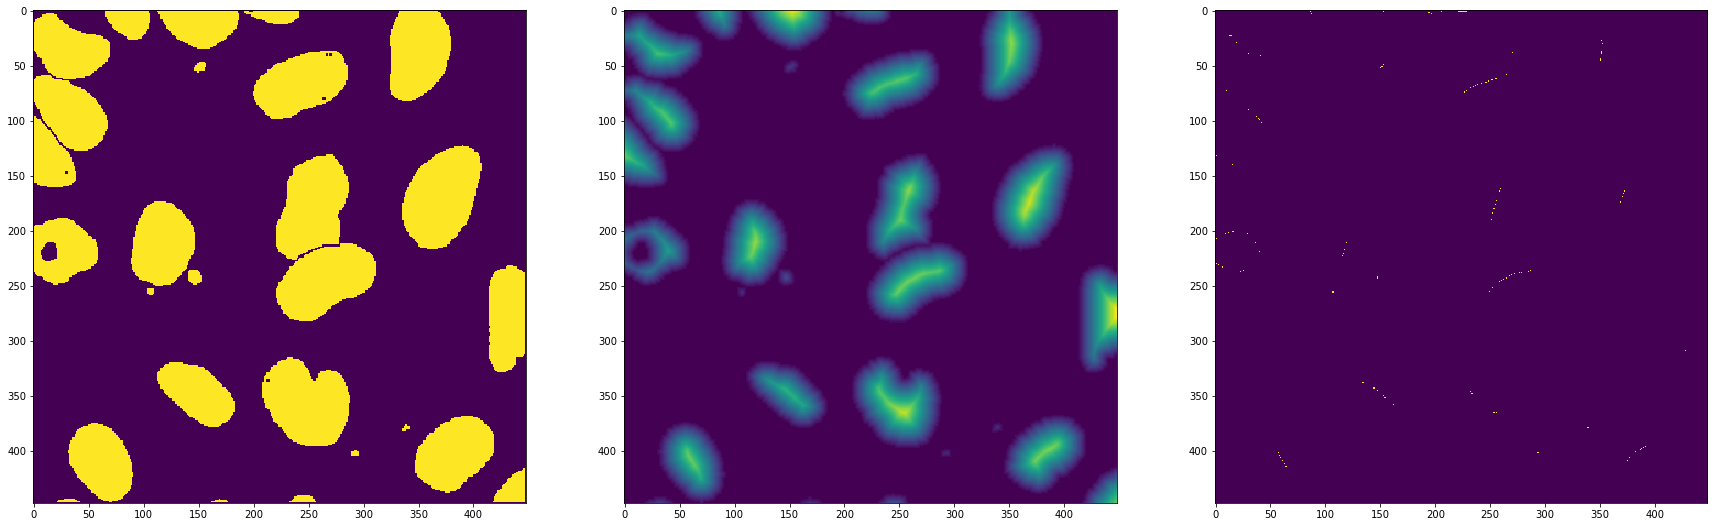

In [42]:
print(np.amax(Y_train_mask[1]), np.amax(Y_train_dist[0]), np.amax(Y_train_maxi[1]))

plt.figure(figsize=(30,20))
plt.subplot(131)
plt.imshow(Y_train_mask[1])
plt.subplot(132)
plt.imshow(Y_train_dist[1])
plt.subplot(133)
plt.imshow(Y_train_maxi[1])

0 374


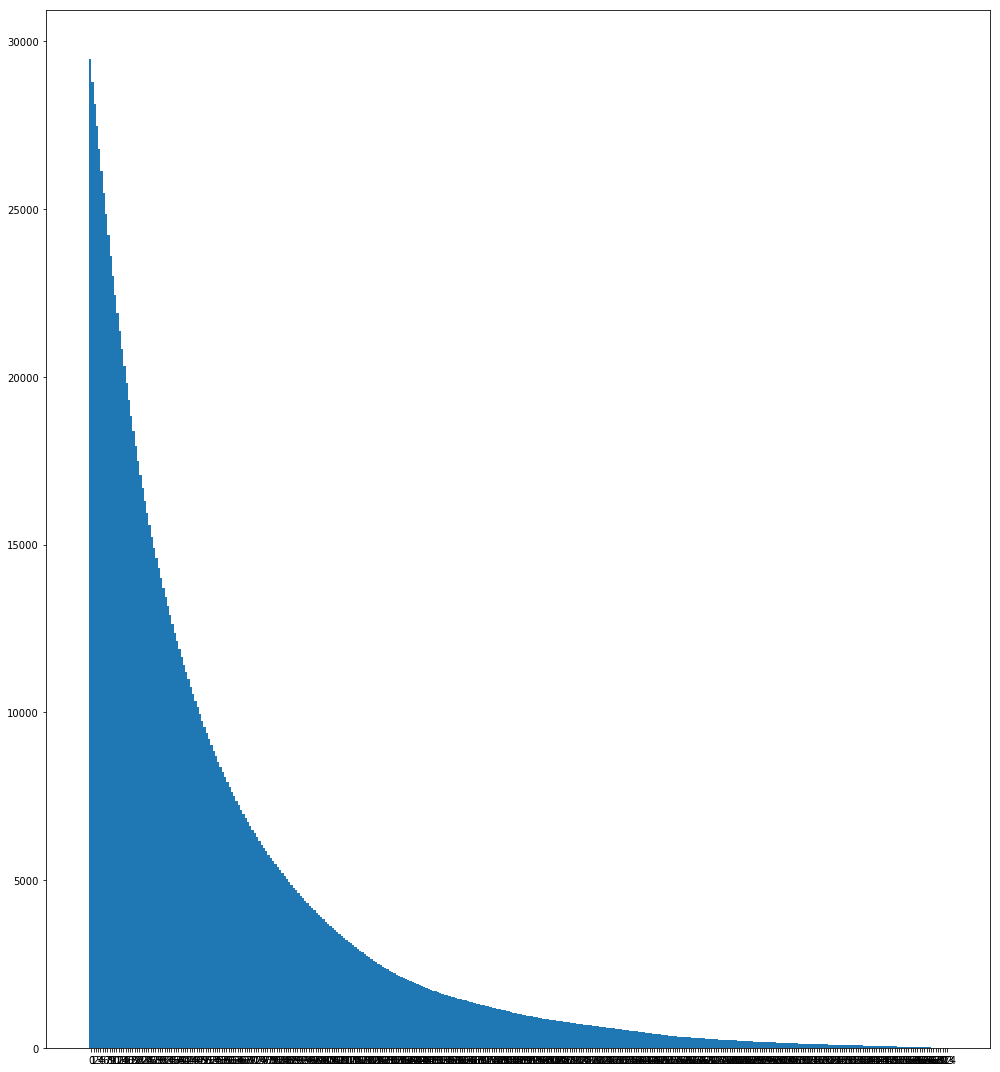

In [9]:
from collections import Counter

from matplotlib import rcParams
rcParams['figure.figsize'] = (14, 15)

all_classes = []

for i in range(len(num_masks)):
    for n in range(num_masks[i]):
        all_classes.extend([m for m in range(n+1)])
        
labels, values = zip(*Counter(all_classes).items())
print(labels[0], labels[-1])

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()
plt.show()

weights = []
max_instances = max(values)
for i, n in enumerate(labels):
    weights.append(max_instances / values[i])


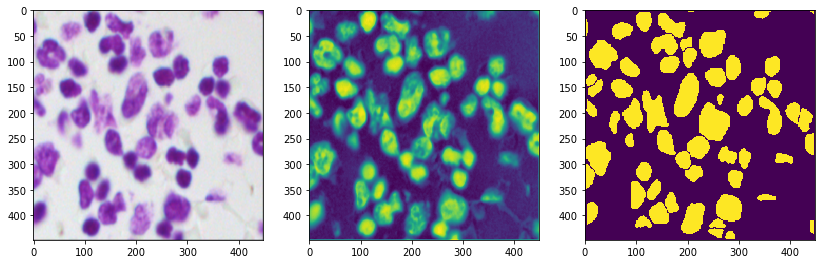

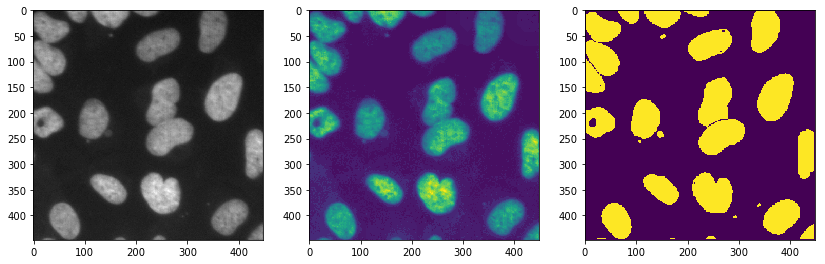

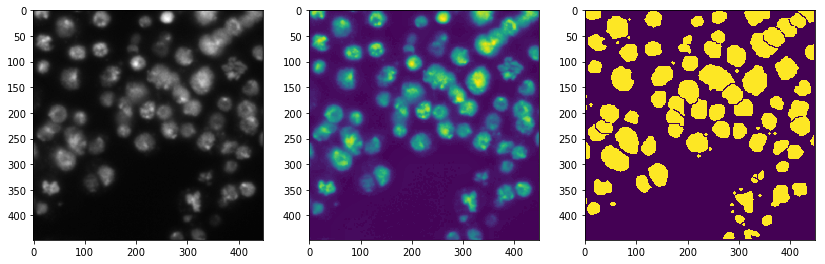

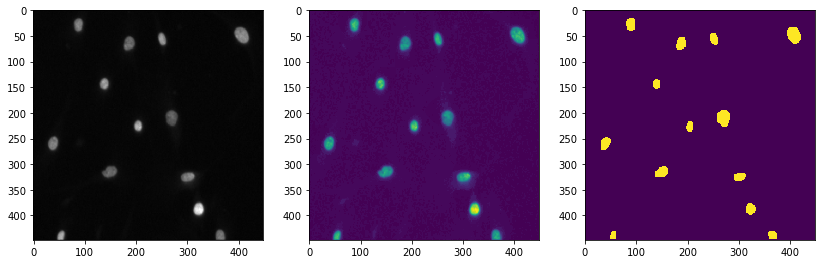

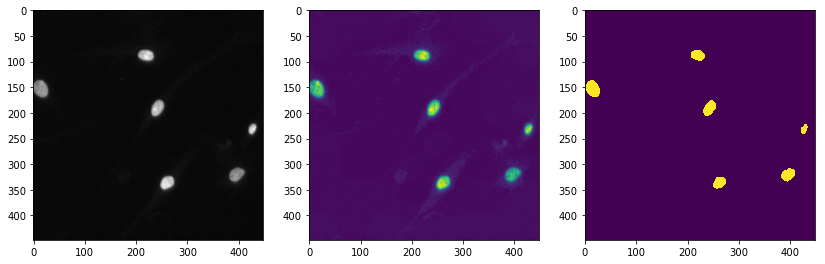

In [10]:
for i in range(5):
    plt.figure()
    plt.subplot(131)
    plt.imshow(X_train[i] / np.max(X_train[i]))
    
    plt.subplot(132)
    plt.imshow(X_train_L[i])
    
    plt.subplot(133)
    plt.imshow(Y_train_m[i].squeeze())
    plt.show()

In [11]:
def random_crop(img, rnd_x, rnd_y, pad):
    orig_y = img.shape[0]
    orig_x = img.shape[1]

    print(img.shape)
    
    img_padded = np.zeros((orig_y + pad*2, orig_x + pad*2))
    img_padded = np.pad(img, ((pad,pad),(pad,pad)), mode='constant')
    
    img_crop = img_padded[rnd_y:orig_y+rnd_y, rnd_x:orig_x+rnd_x]
    
    return img_crop

def transpose_img(img):
    img = np.transpose(img)
    return img

def rotate_img(img, num):
    img = np.rot90(img, num)
    return img

def train_transforms(img_trn, img_tst, u=0.5):
    # verticle flips
    if np.random.random() > u:
        img_trn = np.flip(img_trn, 0)
        img_tst = np.flip(img_tst, 0)
    
    # horizontal flips
    if np.random.random() > u:
        img_trn = np.flip(img_trn, 1)
        img_tst = np.flip(img_tst, 1)
    
    # random rotations
    if np.random.random() > u:
        num = np.random.randint(1,4)
        img_trn = rotate_img(img_trn, num)
        img_tst = rotate_img(img_tst, num)

    if np.random.random() > u:
        img_trn = transpose_img(img_trn)
        img_tst = transpose_img(img_tst)

    # random crops
    if np.random.random() > u:
        # do the random cropping
        pad = 32
        rnd_x = np.random.randint(0, pad*2)
        rnd_y = np.random.randint(0, pad*2)
        img_trn = random_crop(img_trn, rnd_x, rnd_y, pad)
        img_tst = random_crop(img_tst, rnd_x, rnd_y, pad)

    return img_trn, img_tst


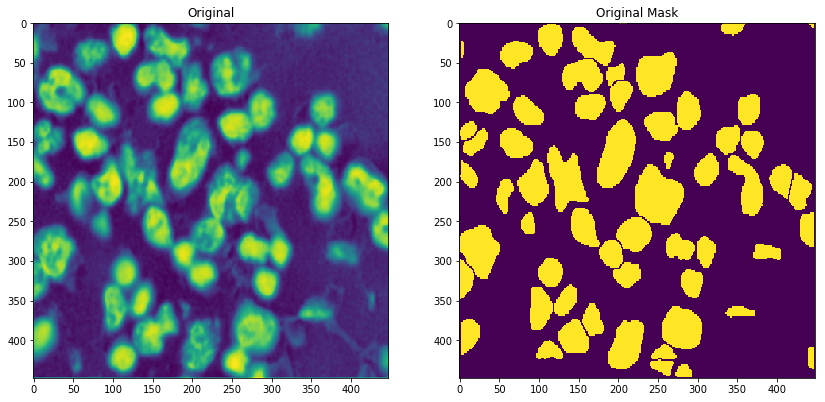

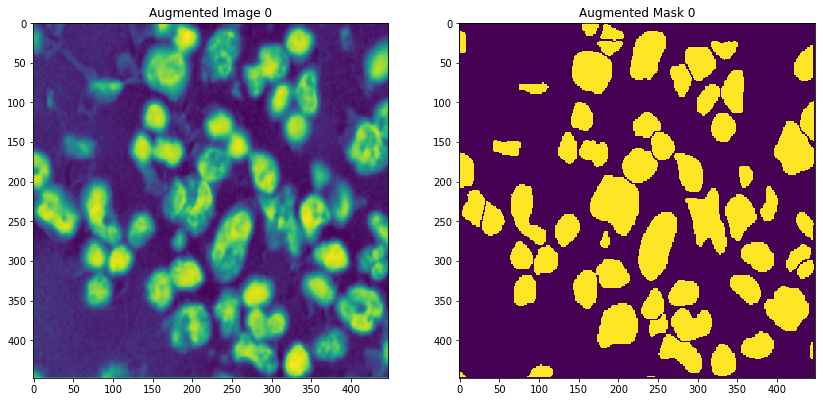

(448, 448)
(448, 448)


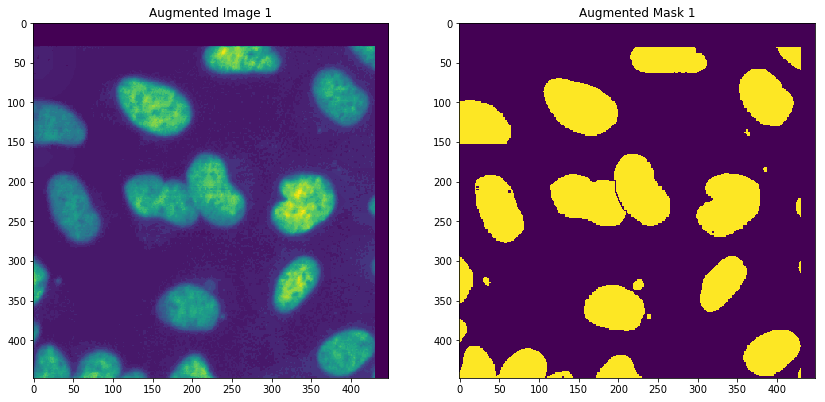

(448, 448)
(448, 448)


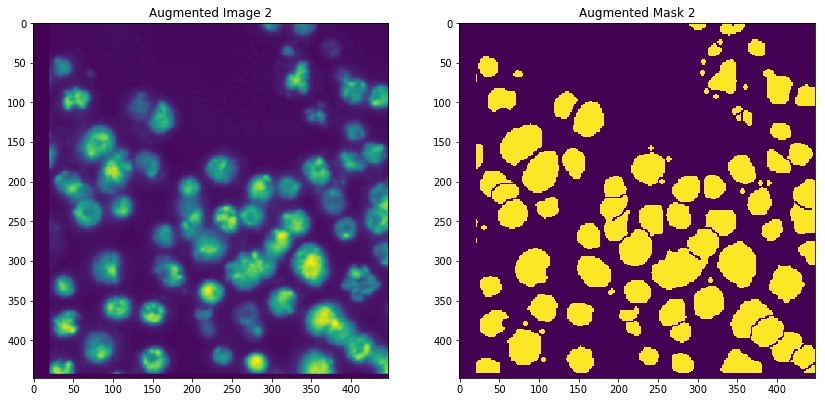

(448, 448)
(448, 448)


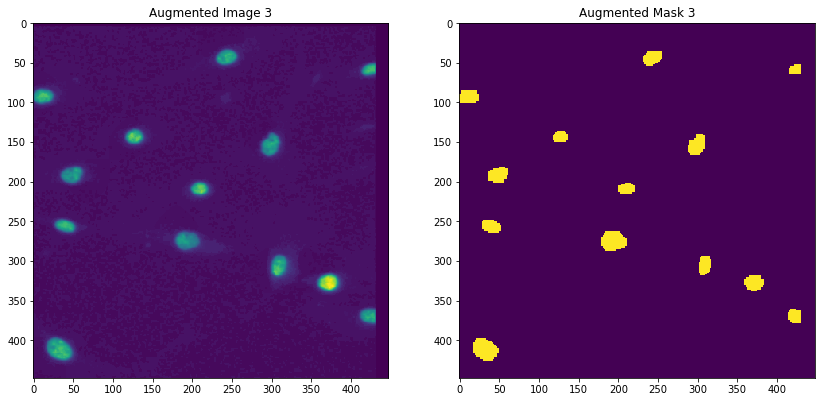

(448, 448)
(448, 448)


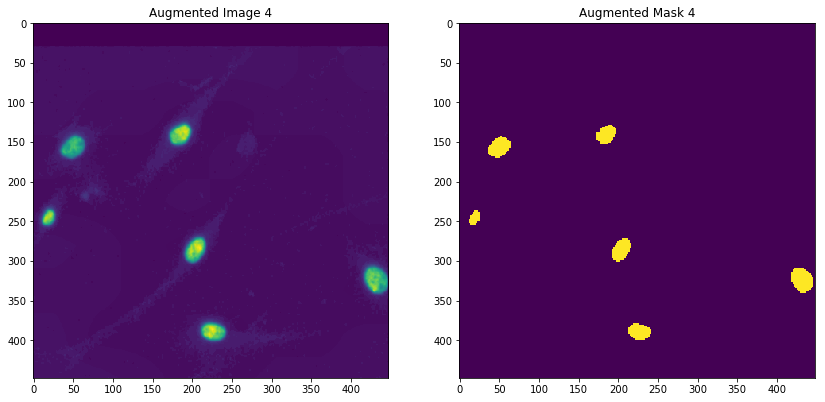

In [12]:
plt.figure()
plt.subplot(121)
plt.imshow(X_train_L[0])
plt.title('Original')

plt.subplot(122)
plt.imshow(Y_train_m[0].squeeze())
plt.title('Original Mask')
plt.show()

for i in range(5):
    img_aug, mask_aug = train_transforms(X_train_L[i], Y_train_m[i].squeeze())

    plt.figure()
    plt.subplot(121)
    plt.imshow(img_aug)
    plt.title('Augmented Image {}'.format(i))

    plt.subplot(122)
    plt.imshow(mask_aug.squeeze())
    plt.title('Augmented Mask {}'.format(i))
    plt.show()

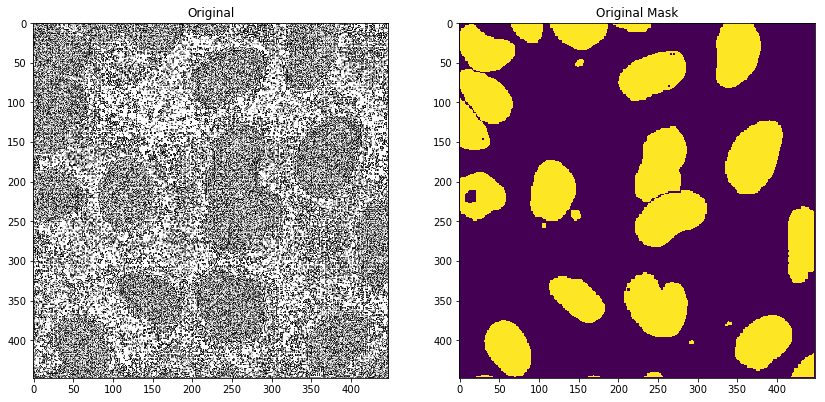

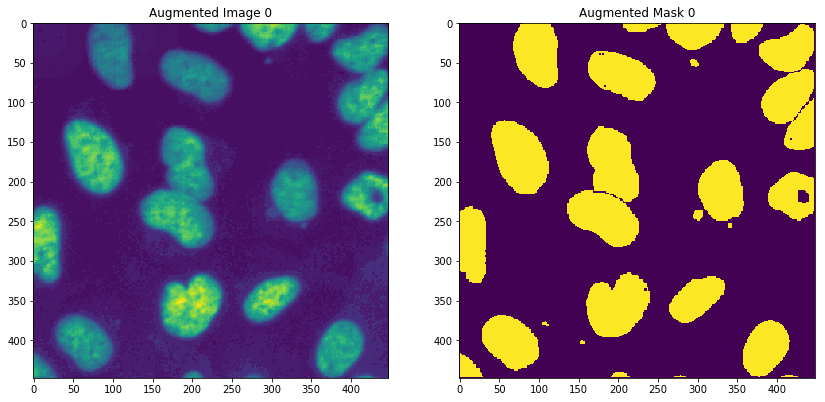

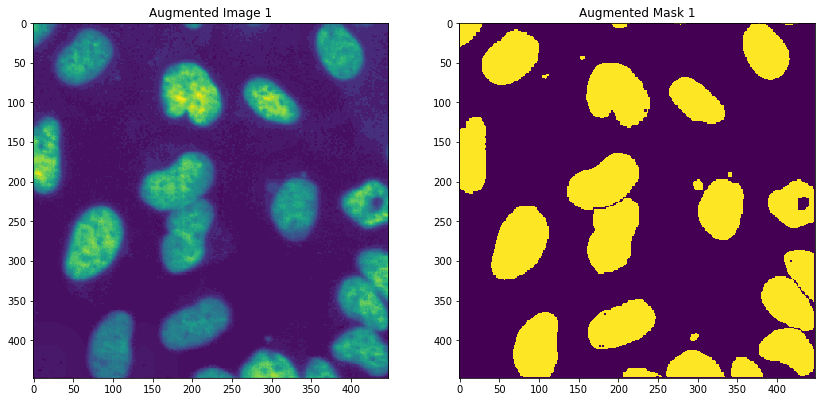

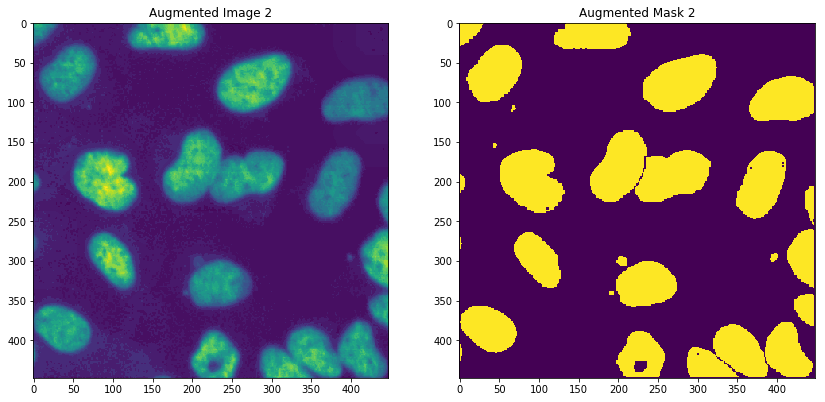

(448, 448)
(448, 448)


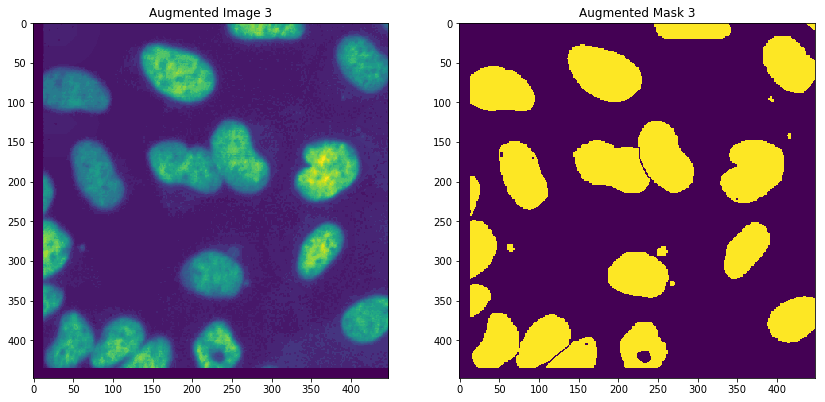

(448, 448)
(448, 448)


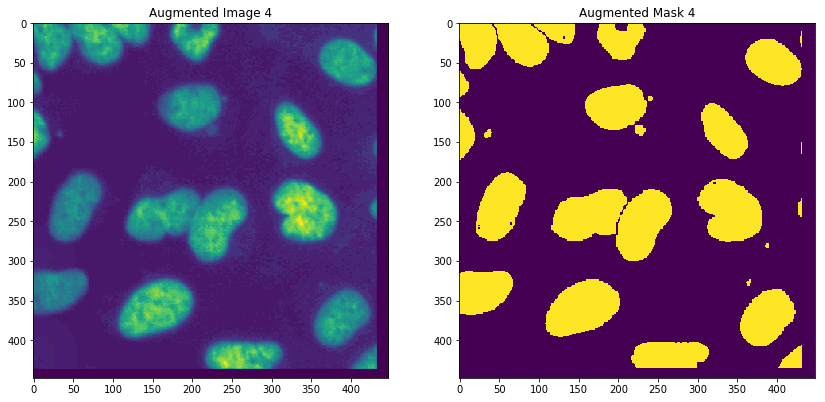

In [13]:
plt.figure()
plt.subplot(121)
plt.imshow(X_train[1])
plt.title('Original')

plt.subplot(122)
plt.imshow(Y_train_m[1].squeeze())
plt.title('Original Mask')
plt.show()

for i in range(5):
    img_aug, mask_aug = train_transforms(X_train_L[1], Y_train_m[1].squeeze())

    plt.figure()
    plt.subplot(121)
    plt.imshow(img_aug)
    plt.title('Augmented Image {}'.format(i))

    plt.subplot(122)
    plt.imshow(mask_aug.squeeze())
    plt.title('Augmented Mask {}'.format(i))
    plt.show()

# Check model predictions on training data

In [43]:
import torch
from models import UNet_Multi

from torch.autograd import Variable
import torch.nn.functional as F

In [45]:
net = UNet_Multi()
net.load_state_dict(torch.load('../models-pytorch/best_SEResUNet_fullimg_lossless_augmentations_full_img.pth'))
net.cpu().eval()

UNet_Multi(
  (conv_1a): Conv2d (3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1b): Conv2d (16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2a): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2b): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3a): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3b): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_4a): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4b): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_5a): Conv2d (128, 256, ker

In [52]:
import glob
X_test = []

test_img_files = glob.glob('../data/image_mask_crops/*_img*')

for n, img_fl in enumerate(test_img_files):
    im_path = TEST_PATH + im_id
    img = imread(img_fl)[:, :, :3] # some images have 4 channels
    img = normalize_img(img)
    #img = resize(img, (PIXELS, PIXELS), mode='constant', preserve_range=True)
    #img = standardize_img(img)
    #img = np.expand_dims(normalize_img(img), -1)
    X_test.append(img.astype(np.float32))
    
print(X_test[0].shape)

(36, 61, 3)


/home/florian/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/florian/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


(128, 128, 3)


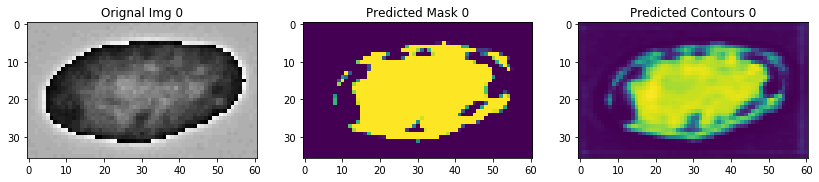

(128, 128, 3)


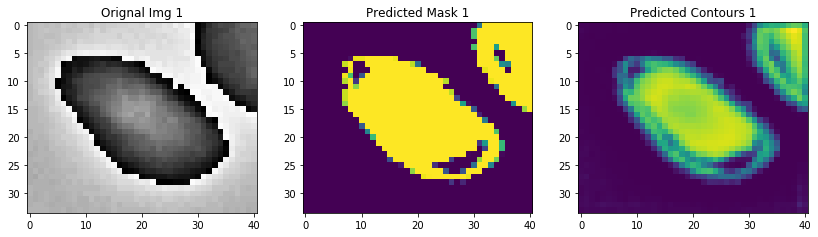

(128, 128, 3)


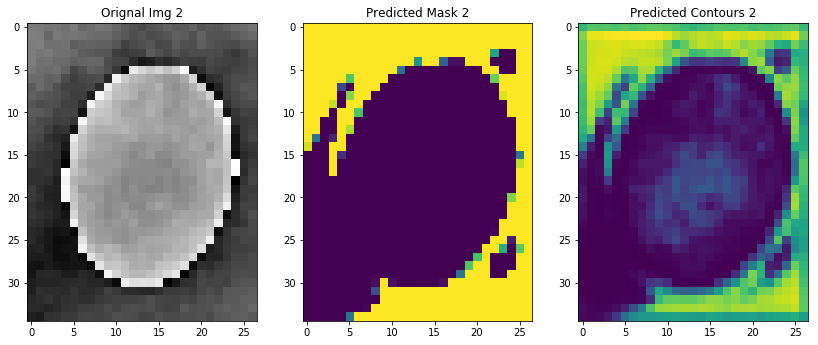

(128, 128, 3)


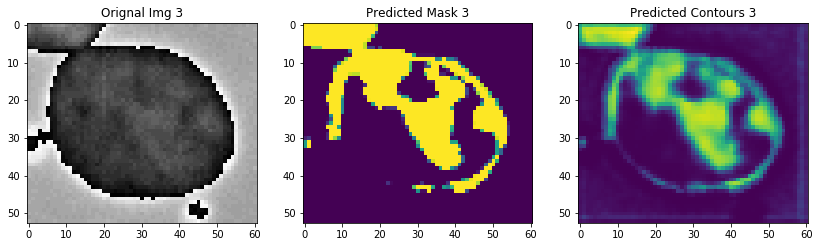

(128, 128, 3)


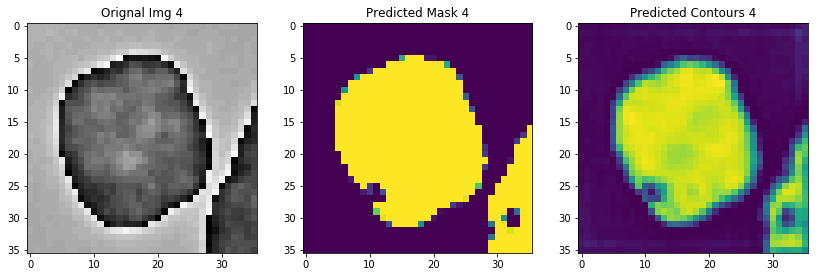

In [60]:
import torch.nn as nn
from scipy import ndimage

from skimage.morphology import label, watershed
from skimage.feature import peak_local_max

from matplotlib import rcParams
rcParams['figure.figsize'] = (14, 15)

def mask_contours(mask, edge):
    edges_ = np.where(edge > 0.5, 1, 0)
    split_mask = mask.astype(np.int32) - edges_.astype(np.int32)
    split_mask = np.where(split_mask < 0.9, 0, 1)
    return split_mask

for i in range(5):
    img = X_test[i]
    img_for_net = resize(img, (128, 128), preserve_range=True)
    print(img_for_net.shape)
    img_for_net = img_for_net.transpose((2,0,1)).reshape((1,3,128,128)).astype(np.float32)
    pred_msk, pred_edg = net(Variable(torch.from_numpy(img_for_net)))
    pred_msk = F.sigmoid(pred_msk)
    pred_edg = F.sigmoid(pred_edg)

    predicted_mask = np.where(pred_msk.data.numpy().squeeze() > 0.5, 1, 0).astype(np.int32)
    predicted_mask = resize(predicted_mask, (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)

    predicted_edge = pred_edg.data.numpy().squeeze()
    predicted_edge = resize(predicted_edge, (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)
    
    plt.figure()
    plt.subplot(131)
    plt.imshow(img.squeeze())
    plt.title('Orignal Img {}'.format(i))

    plt.subplot(132)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask {}'.format(i))
    
    plt.subplot(133)
    plt.imshow(predicted_edge)
    plt.title('Predicted Contours {}'.format(i))
    
    plt.savefig('../img_masks/predicted_mask_contour_{}.png'.format(i))
    plt.show()



In [ ]:
from skimage.color import rgb2grey
from skimage.filters import sobel
from skimage.feature import canny

sobel_raw = sobel(rgb2grey(X_train[0].squeeze()))
sobel_thr = np.where(sobel_raw > 0.01, 1, 0)

plt.imshow(Y_train[0].squeeze())
plt.show()

plt.imshow(sobel_raw)
plt.show()

plt.imshow(sobel_thr)
plt.show()

plt.imshow(canny(sobel(rgb2grey(Y_train[0].squeeze()))))
plt.show()

In [ ]:
im_path = TRAIN_PATH + train_ids[0]

mask = np.zeros((PIXELS, PIXELS), dtype=np.int32)
masks = next(os.walk(im_path + '/masks/'))[2]
for i, mask_file in enumerate(masks):
    mask_ = imread(im_path + '/masks/' + mask_file)
    mask_ = resize(mask_, (PIXELS, PIXELS), mode='constant', preserve_range=True) / 255.
    mask_ = np.where(mask_ == 1, i+1, 0)
    mask = np.add(mask, mask_.astype(np.int32))

plt.imshow(mask.squeeze())
plt.show()

In [ ]:
print(mask)